# GREEN MACHINE ---- Detección de plantas medicinales
## Integrantes:
- Jholman Dasney Meza
- Campos Herney Tulcan
- Juan Camilo Perdomo

In [4]:
!pip install ultralytics roboflow

  Using cached ultralytics-8.3.169-py3-none-any.whl.metadata (37 kB)
  Using cached roboflow-1.2.2-py3-none-any.whl.metadata (9.7 kB)
  Using cached ultralytics_thop-2.0.14-py3-none-any.whl.metadata (9.4 kB)
  Using cached opencv_python_headless-4.10.0.84-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
Using cached ultralytics-8.3.169-py3-none-any.whl (1.0 MB)
Using cached roboflow-1.2.2-py3-none-any.whl (86 kB)
Using cached opencv_python_headless-4.10.0.84-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (49.9 MB)
Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl (664.8 MB)
Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_

In [7]:
!python -V
!pip list | grep torch
!pip list | grep ultralytics

Python 3.11.13
pytorch-ignite                        0.5.2
pytorch-lightning                     2.5.2
torch                                 2.6.0+cu124
torchao                               0.10.0
torchaudio                            2.6.0+cu124
torchdata                             0.11.0
torchinfo                             1.8.0
torchmetrics                          1.7.3
torchsummary                          1.5.1
torchtune                             0.6.1
torchvision                           0.21.0+cu124
ultralytics                           8.3.169
ultralytics-thop                      2.0.14


In [8]:
# Importación de bibliotecas necesarias
import os
import yaml
import gdown
import wandb
import shutil
import requests
import ipywidgets as widgets
import cv2
import numpy as np
from pathlib import Path
from ultralytics import YOLO
from roboflow import Roboflow
from IPython.display import display, Image, clear_output
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import torchvision
import torch.nn as nn
from torchvision.io import ImageReadMode
import torchvision.transforms.functional as TF

# Deshabilitar Weights & Biases para evitar registros innecesarios
os.environ['WANDB_DISABLED'] = 'true'

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [9]:
# Descarga del conjunto de datos desde Roboflow
rf = Roboflow(api_key="dk51AFjSWjBjMwGA0ybh")  # Clave de API para autenticación
project = rf.workspace("jmezapp").project("green_machinev2-nxegl")  # Proyecto en Roboflow
version = project.version(2)  # Versión específica del conjunto de datos
dataset = version.download("folder")  # Descarga en formato compatible con YOLOv8
dataset_dir = dataset.location

loading Roboflow workspace...
loading Roboflow project...
Exporting format folder in progress : 85.0%
Version export complete for folder format



Extracting Dataset Version Zip to Green_MachineV2-2 in folder:: 100%|██████████| 3289/3289 [00:00<00:00, 3940.28it/s]


In [10]:
!find {dataset_dir} -maxdepth 2 -type d

/kaggle/working/Green_MachineV2-2
/kaggle/working/Green_MachineV2-2/valid
/kaggle/working/Green_MachineV2-2/valid/Peumus boldus (Boldo)
/kaggle/working/Green_MachineV2-2/valid/Dysphania ambrosioides (Paico)
/kaggle/working/Green_MachineV2-2/valid/Erythroxylum coca (coca)
/kaggle/working/Green_MachineV2-2/valid/Alo evera (SÃ¡bila)
/kaggle/working/Green_MachineV2-2/valid/Eryngium foetidum (CimarrÃ³n)
/kaggle/working/Green_MachineV2-2/valid/Chamaemelum nobile (Manzanilla)
/kaggle/working/Green_MachineV2-2/valid/Ruta graveolens (Ruda)
/kaggle/working/Green_MachineV2-2/valid/Valeriana officinalis (Valeriana)
/kaggle/working/Green_MachineV2-2/valid/PlantasNoMedicinales
/kaggle/working/Green_MachineV2-2/valid/Mentha spicata (Hierbabuena)
/kaggle/working/Green_MachineV2-2/valid/Calendula officinalis (Calendula)
/kaggle/working/Green_MachineV2-2/train
/kaggle/working/Green_MachineV2-2/train/Peumus boldus (Boldo)
/kaggle/working/Green_MachineV2-2/train/Dysphania ambrosioides (Paico)
/kaggle/work

In [11]:
cfg = {
    'train': 'train',
    'val':   'valid',
    'test':  'test',   
    'names': [
        'Alo evera (SÃ¡bila)',
        'Calendula officinalis (Calendula)',
        'Chamaemelum nobile (Manzanilla)',
        'Dysphania ambrosioides (Paico)',
        'Eryngium foetidum (CimarrÃ³n)',
        'Erythroxylum coca (coca)',
        'Mentha spicata (Hierbabuena)',
        'Peumus boldus (Boldo)',
        'PlantasNoMedicinales',
        'Ruta graveolens (Ruda)',
        'Valeriana officinalis (Valeriana)'
    ]
}

yaml_path = os.path.join(dataset_dir, 'data.yaml')   
with open(yaml_path, 'w') as f:
    yaml.safe_dump(cfg, f, sort_keys=False)

print("data.yaml creado en:", yaml_path)


data.yaml creado en: /kaggle/working/Green_MachineV2-2/data.yaml


In [14]:
model = YOLO('yolov8s-cls.pt')
results = model.train(
    task='classify',
    data=dataset_dir,    
    epochs=50,
    imgsz=640,
    batch=32,
    device=[0,1],        
    patience=10,
    plots=True
)

Ultralytics 8.3.169 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
                                                        CUDA:1 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/Green_MachineV2-2, degrees=0.0, deterministic=True, device=0,1, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s-cls.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train2, nbs=64, nms=False, opset=None, optimize=False, optimi

train: Scanning /kaggle/working/Green_MachineV2-2/train... 2838 images, 0 corrupt: 100%|██████████| 2838/2838 [00:00<?, ?it/s]
val: Scanning /kaggle/working/Green_MachineV2-2/valid... 279 images, 0 corrupt: 100%|██████████| 279/279 [00:00<?, ?it/s]


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000667, momentum=0.9) with parameter groups 26 weight(decay=0.0), 27 weight(decay=0.0005), 27 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/classify/train2
Starting training for 50 epochs...

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:02<00:00,  3.23it/s]


                   all      0.591      0.918

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:02<00:00,  4.04it/s]


                   all      0.763      0.971

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:02<00:00,  4.09it/s]


                   all      0.814      0.978

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:02<00:00,  3.92it/s]


                   all      0.878      0.993

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:02<00:00,  3.58it/s]


                   all      0.867      0.982

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:02<00:00,  3.99it/s]


                   all      0.871      0.989

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:02<00:00,  4.08it/s]


                   all      0.849      0.989

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:02<00:00,  4.23it/s]


                   all      0.867      0.986

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:02<00:00,  3.39it/s]


                   all      0.871          1


      10/50      3.09G     0.3169         16        640:   1%|          | 1/89 [00:00<00:15,  5.75it/s]


      Epoch    GPU_mem       loss  Instances       Size


      10/50      3.09G     0.1298         11        640: 100%|██████████| 89/89 [00:48<00:00,  1.84it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:02<00:00,  4.12it/s]


                   all      0.867          1

      Epoch    GPU_mem       loss  Instances       Size


      11/50       3.1G     0.1535         11        640: 100%|██████████| 89/89 [00:46<00:00,  1.90it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:02<00:00,  3.81it/s]


                   all      0.875      0.989


  0%|          | 0/89 [00:00<?, ?it/s]


      Epoch    GPU_mem       loss  Instances       Size


      12/50       3.1G    0.08479         11        640: 100%|██████████| 89/89 [00:47<00:00,  1.89it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:02<00:00,  4.03it/s]


                   all      0.896      0.996

      Epoch    GPU_mem       loss  Instances       Size


      13/50      3.11G     0.1017         11        640: 100%|██████████| 89/89 [00:46<00:00,  1.92it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:02<00:00,  4.11it/s]


                   all       0.91      0.996

      Epoch    GPU_mem       loss  Instances       Size


      14/50      3.12G    0.07798         11        640: 100%|██████████| 89/89 [00:47<00:00,  1.88it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:01<00:00,  4.51it/s]


                   all      0.892      0.989

      Epoch    GPU_mem       loss  Instances       Size


      15/50      3.12G    0.08494         11        640: 100%|██████████| 89/89 [00:46<00:00,  1.91it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:02<00:00,  3.35it/s]


                   all      0.885      0.996

      Epoch    GPU_mem       loss  Instances       Size


      16/50      3.12G    0.08155         11        640: 100%|██████████| 89/89 [00:47<00:00,  1.88it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:02<00:00,  4.20it/s]


                   all      0.896      0.996

      Epoch    GPU_mem       loss  Instances       Size


      17/50      3.12G    0.08942         11        640: 100%|██████████| 89/89 [00:48<00:00,  1.85it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:02<00:00,  3.93it/s]


                   all       0.91      0.993

      Epoch    GPU_mem       loss  Instances       Size


      18/50      3.12G    0.06835         11        640: 100%|██████████| 89/89 [00:47<00:00,  1.88it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:02<00:00,  4.32it/s]


                   all      0.914      0.996

      Epoch    GPU_mem       loss  Instances       Size


      19/50      3.12G    0.06667         11        640: 100%|██████████| 89/89 [00:48<00:00,  1.85it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:02<00:00,  3.69it/s]


                   all      0.914          1

      Epoch    GPU_mem       loss  Instances       Size


      20/50      3.12G    0.05536         11        640: 100%|██████████| 89/89 [00:47<00:00,  1.86it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:02<00:00,  4.47it/s]


                   all      0.928          1

      Epoch    GPU_mem       loss  Instances       Size


      21/50      3.12G    0.05648         11        640: 100%|██████████| 89/89 [00:48<00:00,  1.82it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:02<00:00,  4.20it/s]


                   all      0.925      0.989

      Epoch    GPU_mem       loss  Instances       Size


      22/50      3.12G    0.05815         11        640: 100%|██████████| 89/89 [00:47<00:00,  1.86it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:02<00:00,  4.27it/s]


                   all        0.9      0.996


      23/50      3.12G     0.1899         16        640:   1%|          | 1/89 [00:00<00:12,  7.16it/s]


      Epoch    GPU_mem       loss  Instances       Size


      23/50      3.12G    0.05513         11        640: 100%|██████████| 89/89 [00:47<00:00,  1.86it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:02<00:00,  3.68it/s]


                   all        0.9      0.993

      Epoch    GPU_mem       loss  Instances       Size


      24/50      3.12G    0.04773         11        640: 100%|██████████| 89/89 [00:47<00:00,  1.86it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:02<00:00,  3.84it/s]


                   all      0.903      0.993

      Epoch    GPU_mem       loss  Instances       Size


      25/50      3.12G    0.05155         11        640: 100%|██████████| 89/89 [00:47<00:00,  1.87it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:02<00:00,  3.84it/s]


                   all      0.896      0.993

      Epoch    GPU_mem       loss  Instances       Size


      26/50      3.12G    0.02658         11        640: 100%|██████████| 89/89 [00:48<00:00,  1.83it/s]
               classes   top1_acc   top5_acc:  78%|███████▊  | 7/9 [00:01<00:00,  3.18it/s]

                   all      0.896      0.989


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:02<00:00,  4.27it/s]



      Epoch    GPU_mem       loss  Instances       Size


      27/50      3.12G     0.0467         11        640: 100%|██████████| 89/89 [00:47<00:00,  1.88it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:02<00:00,  4.09it/s]


                   all      0.907          1

      Epoch    GPU_mem       loss  Instances       Size


      28/50      3.12G    0.05117         11        640: 100%|██████████| 89/89 [00:48<00:00,  1.84it/s]
               classes   top1_acc   top5_acc:  89%|████████▉ | 8/9 [00:01<00:00,  4.06it/s]

                   all       0.91      0.996


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:01<00:00,  4.58it/s]



      Epoch    GPU_mem       loss  Instances       Size


      29/50      3.12G    0.04227         11        640: 100%|██████████| 89/89 [00:47<00:00,  1.89it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:02<00:00,  3.99it/s]


                   all      0.907      0.993

      Epoch    GPU_mem       loss  Instances       Size


      30/50      3.12G    0.03384         11        640: 100%|██████████| 89/89 [00:48<00:00,  1.85it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:02<00:00,  4.11it/s]


                   all      0.903      0.989
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 20, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

30 epochs completed in 0.422 hours.
Optimizer stripped from runs/classify/train2/weights/last.pt, 10.3MB
Optimizer stripped from runs/classify/train2/weights/best.pt, 10.3MB

Validating runs/classify/train2/weights/best.pt...
Ultralytics 8.3.169 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
                                                        CUDA:1 (Tesla T4, 15095MiB)
YOLOv8s-cls summary (fused): 30 layers, 5,089,291 parameters, 0 gradients, 12.5 GFLOPs
train: /kaggle/working/Green_MachineV2-2/train... found 2838 images in 11 classes ✅ 
val: /kaggle/working/Green_MachineV2-2/valid... found 279 images in 11 classes ✅ 
test: /kaggle/working/Green_M

               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:02<00:00,  3.15it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all      0.928          1
Speed: 0.7ms preprocess, 2.4ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/train2


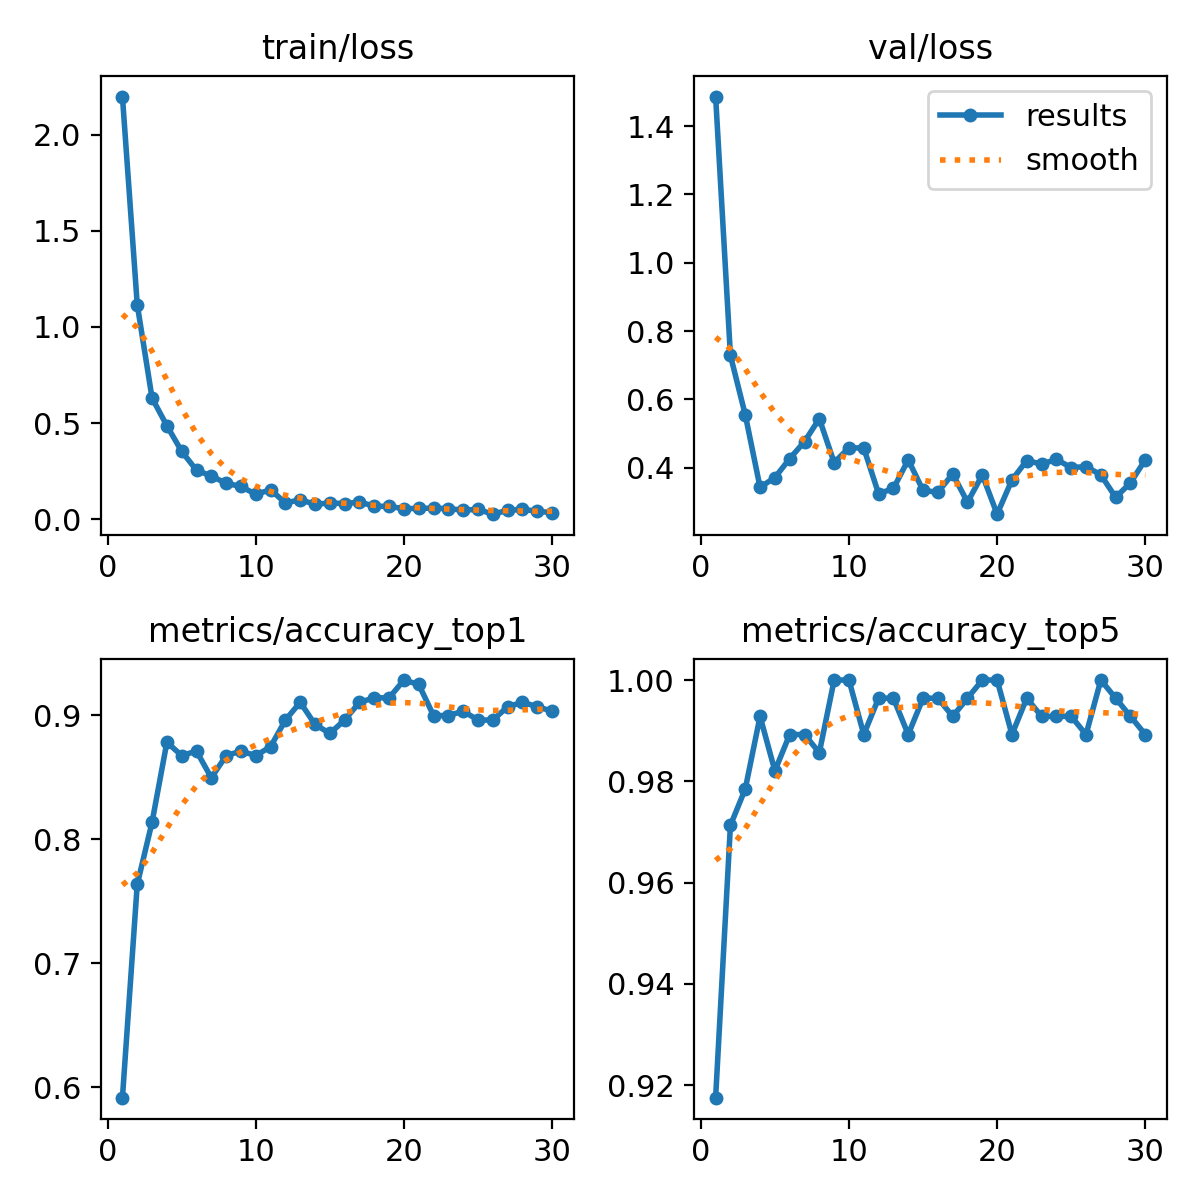

In [15]:
from IPython.display import Image, display

exp_dir = "runs/classify/train"   # Carpeta entrenamiento
# Gráfico de resultados
display(Image(filename=f"{exp_dir}/results.png"))

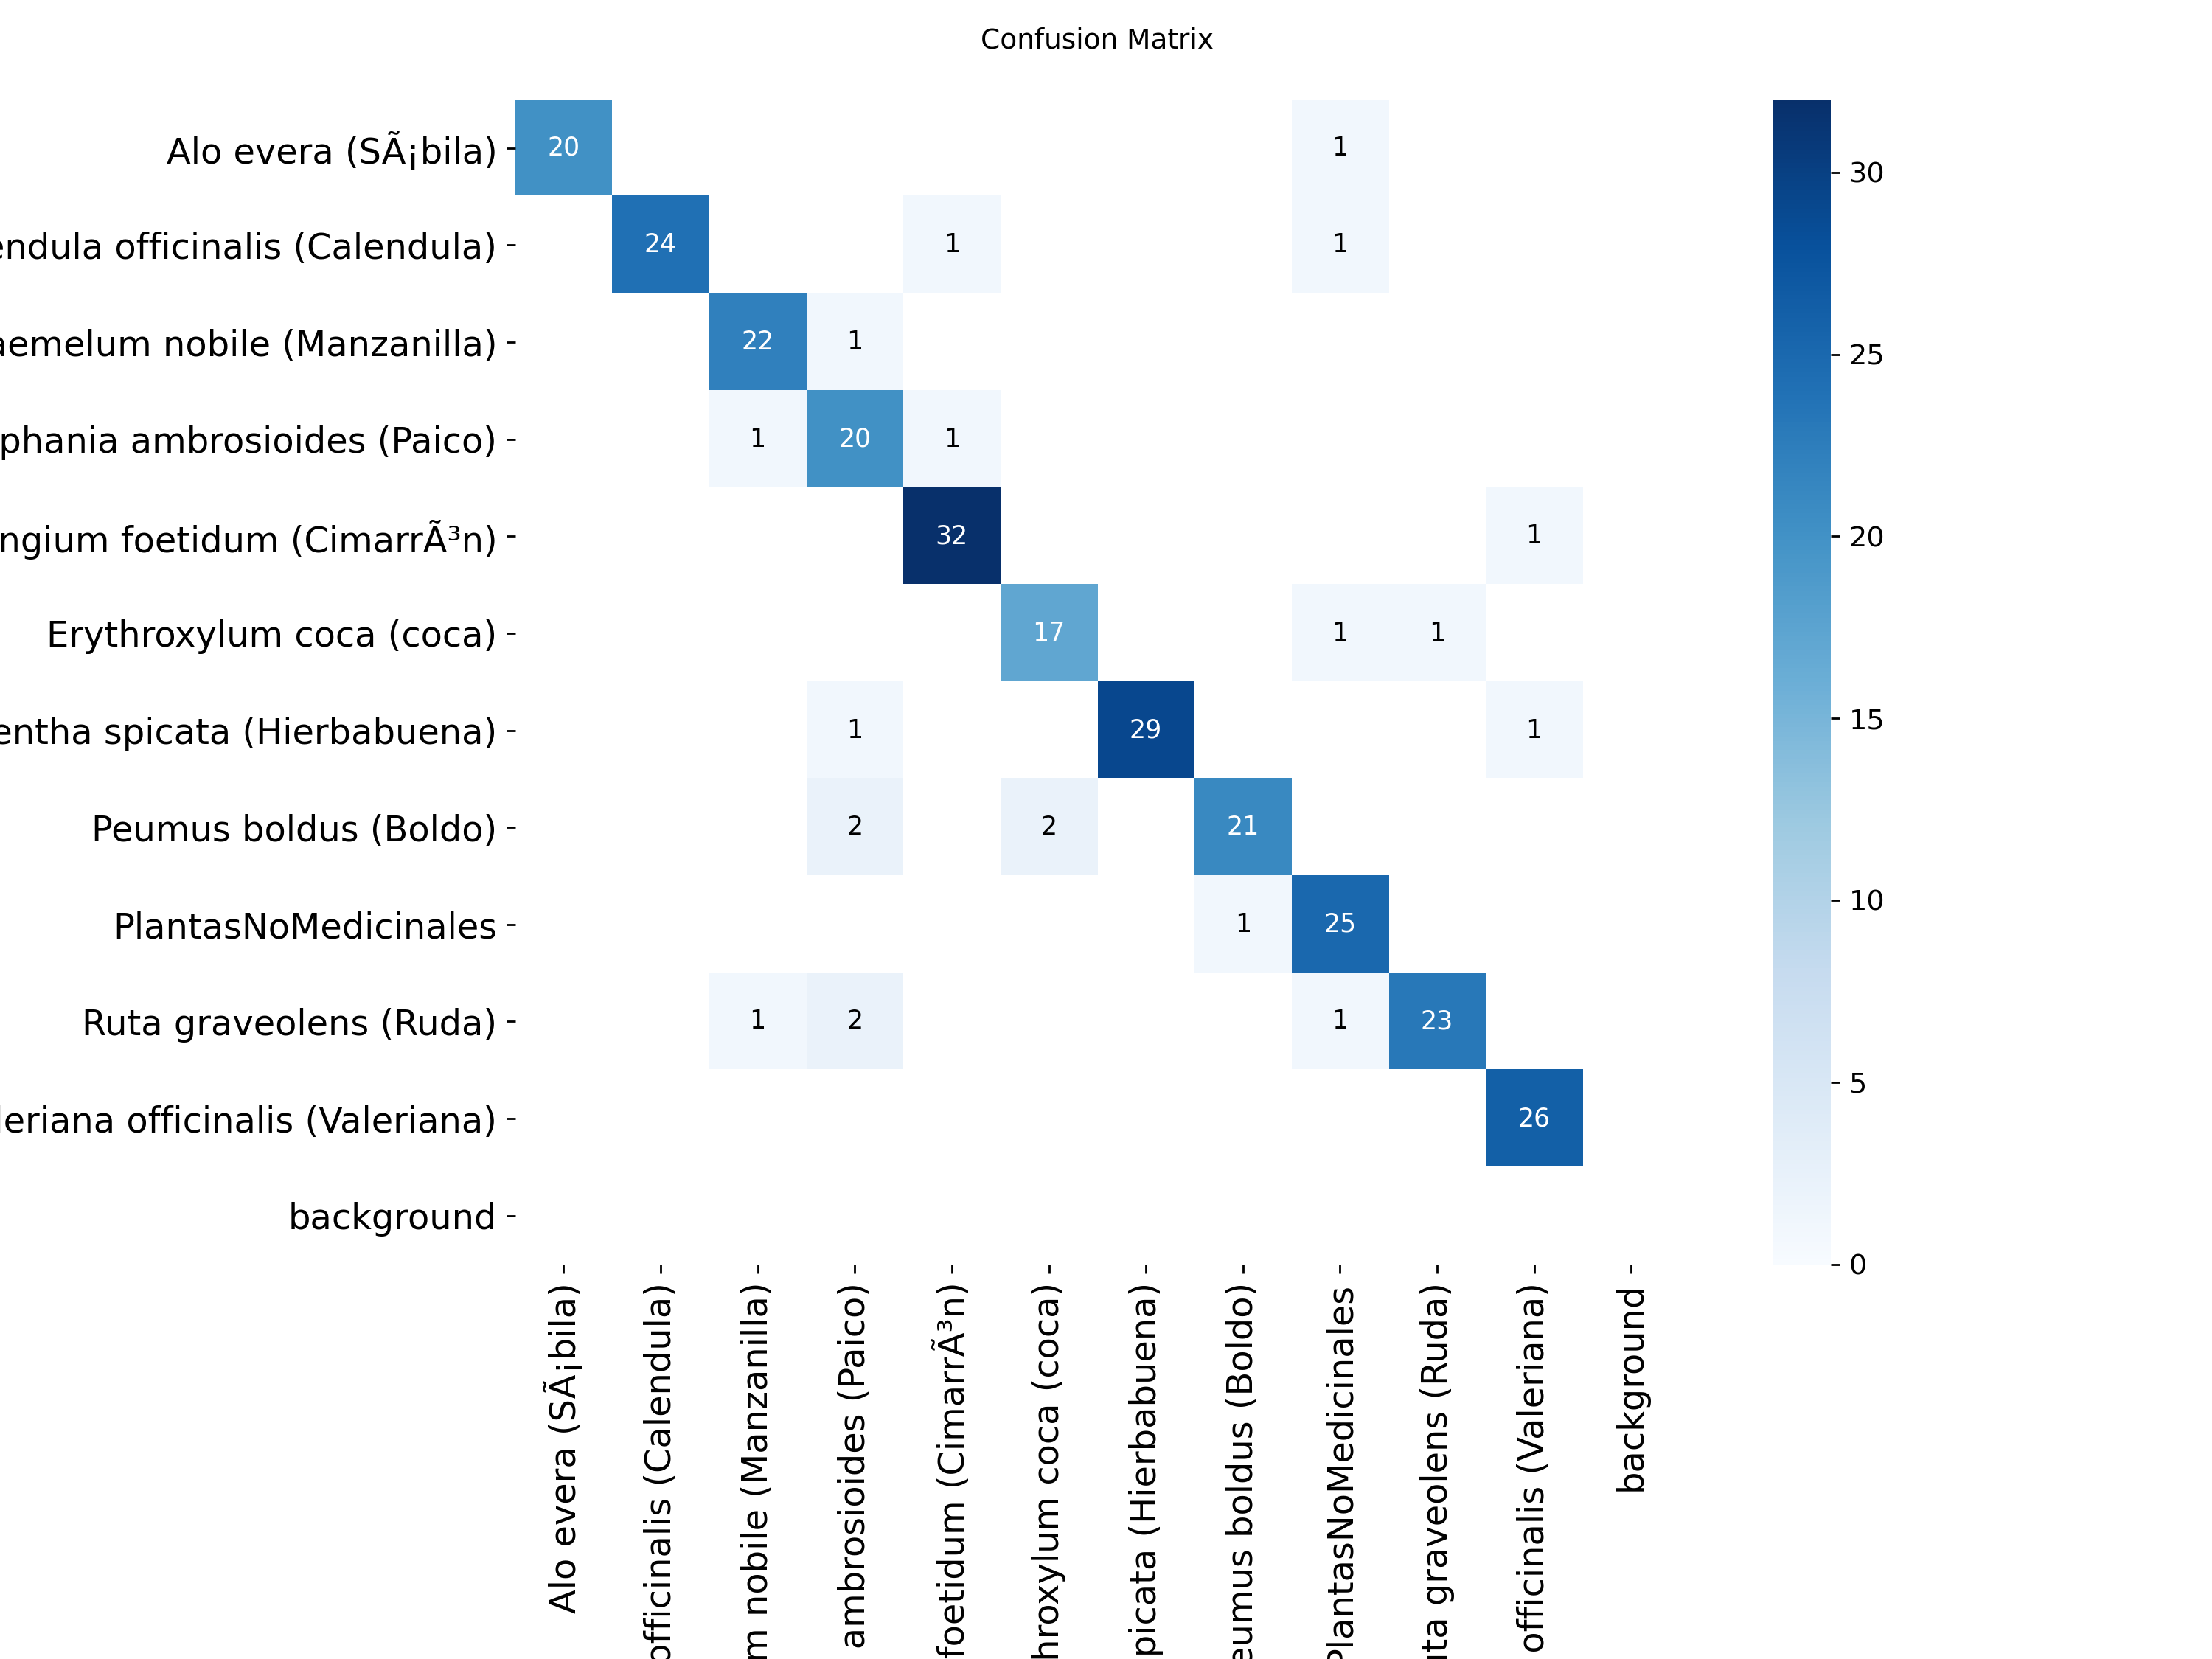

In [16]:
# Matriz de confusión (confusion_matrix.png
display(Image(filename=f"{exp_dir}/confusion_matrix.png"))

YOLOv8s-cls summary (fused): 30 layers, 5,089,291 parameters, 0 gradients, 12.5 GFLOPs


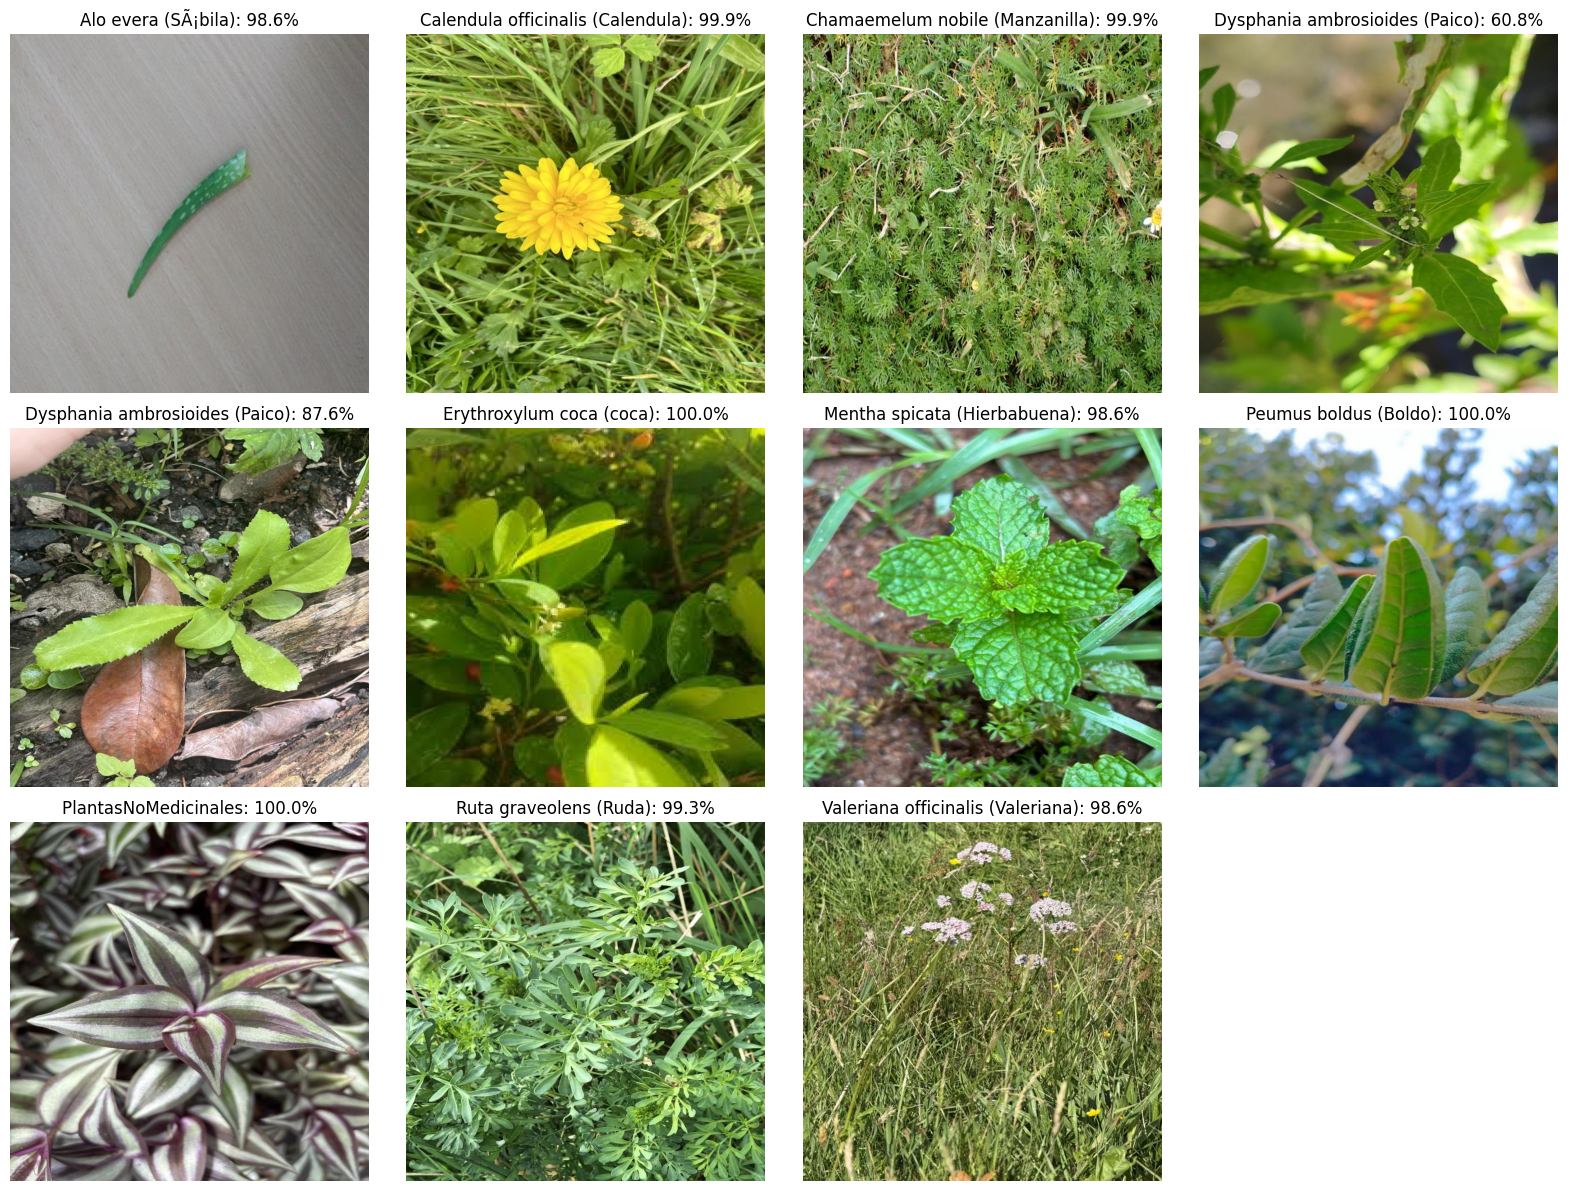


Accuracy total: 91.04%

Reporte de Clasificación:
                                   precision    recall  f1-score   support

              Alo evera (SÃ¡bila)      1.000     1.000     1.000         9
Calendula officinalis (Calendula)      0.692     1.000     0.818         9
  Chamaemelum nobile (Manzanilla)      1.000     1.000     1.000         9
   Dysphania ambrosioides (Paico)      0.769     1.000     0.870        10
    Eryngium foetidum (CimarrÃ³n)      0.917     0.917     0.917        12
         Erythroxylum coca (coca)      1.000     0.900     0.947        10
     Mentha spicata (Hierbabuena)      1.000     0.762     0.865        21
            Peumus boldus (Boldo)      1.000     0.929     0.963        14
             PlantasNoMedicinales      0.846     0.786     0.815        14
           Ruta graveolens (Ruda)      1.000     1.000     1.000         9
Valeriana officinalis (Valeriana)      0.889     0.941     0.914        17

                         accuracy              

In [62]:
import os
import random
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from ultralytics import YOLO
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score

# Carga el modelo entrenado
model = YOLO('/kaggle/working/runs/classify/train/weights/best.pt')
model.fuse()

# Carpeta de test
test_root = '/kaggle/working/Green_MachineV2-2/test'

# Lista de clases desde el modelo
if isinstance(model.names, dict):
    class_names = [model.names[i] for i in sorted(model.names.keys())]
else:
    class_names = list(model.names)

# Elegir aleatoriamente 1 imagen por clase para el collage
image_paths = []
for cls in class_names:
    cls_dir = os.path.join(test_root, cls)
    imgs = [os.path.join(cls_dir, f) for f in os.listdir(cls_dir) if f.lower().endswith(('.jpg','.jpeg','.png'))]
    if imgs:
        image_paths.append(random.choice(imgs))

n = len(image_paths)
cols = math.ceil(math.sqrt(n))
rows = math.ceil(n / cols)

# Crear el collage
fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*4))
axes = axes.flatten()

for ax, img_path in zip(axes, image_paths):
    img = mpimg.imread(img_path)
    ax.imshow(img)
    ax.axis('off')
    results = model.predict(source=img_path, task='classify', imgsz=640, device=0, verbose=False)
    p = results[0].probs
    idx = int(p.top1)
    conf = float(p.top1conf) * 100.0
    label = model.names[idx]
    ax.set_title(f"{label}: {conf:.1f}%", fontsize=12)

for ax in axes[n:]:
    ax.axis('off')

plt.tight_layout()
plt.show()

# =============================
# Evaluación completa del test
# =============================

y_true = []
y_pred = []
class_to_idx = {name: i for i, name in enumerate(class_names)}

for cls_name in class_names:
    cls_dir = os.path.join(test_root, cls_name)
    imgs = [os.path.join(cls_dir, f) for f in os.listdir(cls_dir) if f.lower().endswith(('.jpg','.jpeg','.png'))]
    for img_path in imgs:
        results = model.predict(source=img_path, task='classify', imgsz=640, device=0, verbose=False)
        pred_idx = int(results[0].probs.top1)
        y_true.append(class_to_idx[cls_name])
        y_pred.append(pred_idx)

# Accuracy
acc = accuracy_score(y_true, y_pred)
print(f"\nAccuracy total: {acc*100:.2f}%")

# Classification Report
print("\nReporte de Clasificación:")
print(classification_report(y_true, y_pred, target_names=class_names, digits=3))



In [20]:
"""## Exportación del Modelo a TorchScript

Se exporta el modelo entrenado a formato TorchScript y se implementan funciones para cargar el modelo, preprocesar imágenes y realizar inferencias.
"""

# Exportar el modelo a formato TorchScript
model = YOLO("/kaggle/working/runs/classify/train2/weights/best.pt")
model.export(
    format='torchscript',  # Formato de exportación
    imgsz=640,            # Tamaño de las imágenes
    data=yaml_path,        # Ruta al archivo YAML
    half=False
)
print("Modelo exportado a TorchScript.")

Ultralytics 8.3.169 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.00GHz)
💡 ProTip: Export to OpenVINO format for best performance on Intel hardware. Learn more at https://docs.ultralytics.com/integrations/openvino/
YOLOv8s-cls summary (fused): 30 layers, 5,089,291 parameters, 0 gradients, 12.5 GFLOPs

PyTorch: starting from '/kaggle/working/runs/classify/train2/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 11) (9.8 MB)

TorchScript: starting export with torch 2.6.0+cu124...
TorchScript: export success ✅ 1.5s, saved as '/kaggle/working/runs/classify/train2/weights/best.torchscript' (19.6 MB)

Export complete (2.3s)
Results saved to /kaggle/working/runs/classify/train2/weights
Predict:         yolo predict task=classify model=/kaggle/working/runs/classify/train2/weights/best.torchscript imgsz=640  
Validate:        yolo val task=classify model=/kaggle/working/runs/classify/train2/weights/best.torchscript imgsz=640 data=/kaggle/working/Green_Machin

Modelo TorchScript cargado desde /kaggle/working/runs/classify/train/weights/best.torchscript en cpu


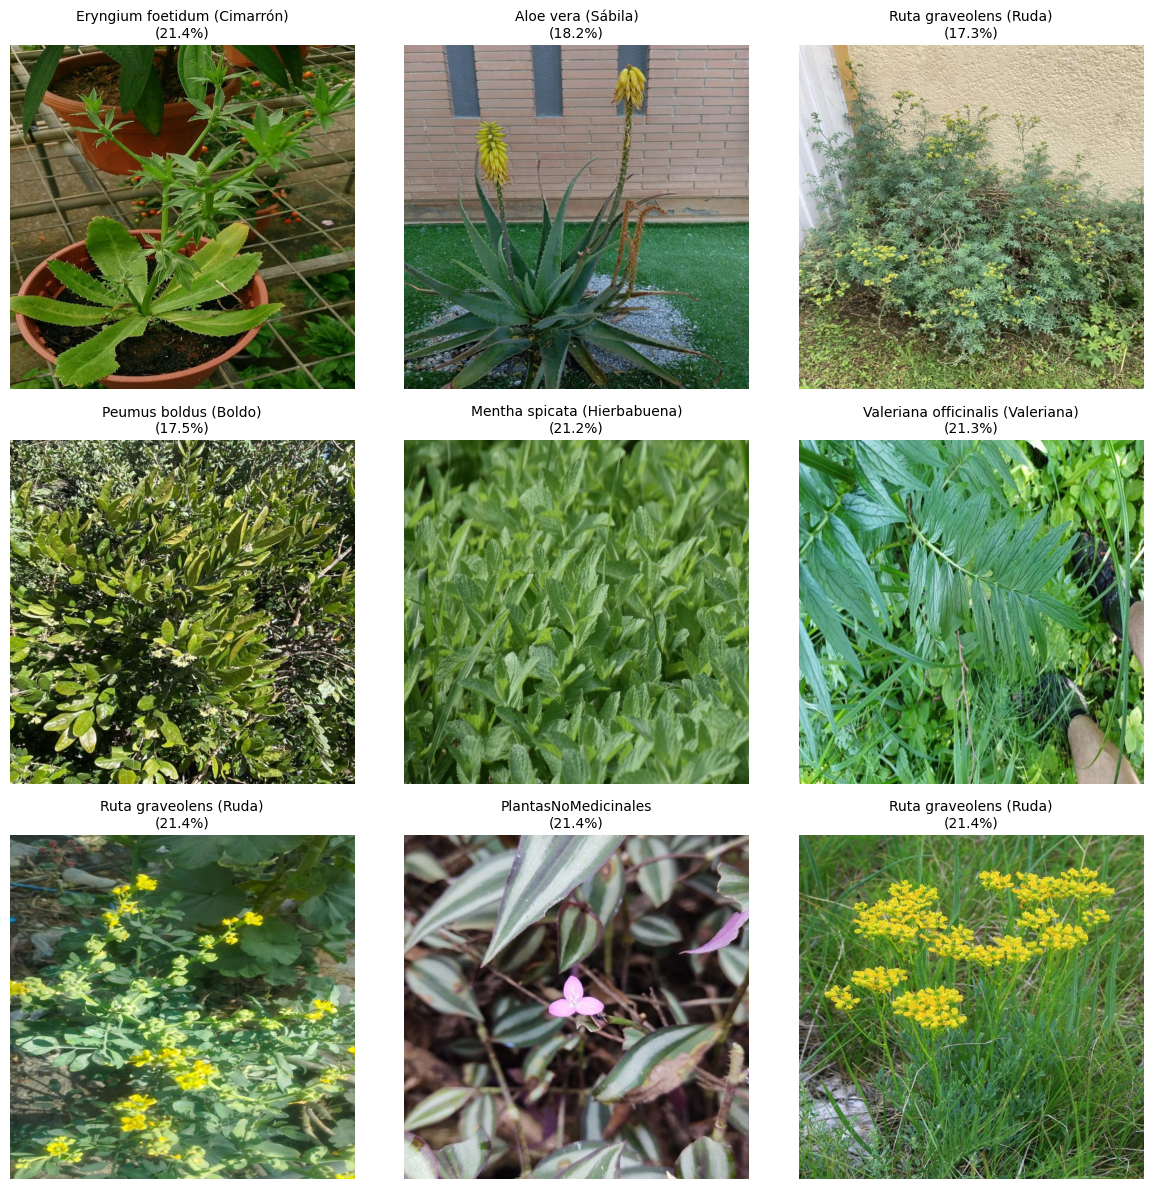

In [55]:
import os
import cv2
import time
import torch
import random
import matplotlib.pyplot as plt

# Clases
class_names = [
    'Aloe vera (Sábila)',
    'Calendula officinalis (Calendula)',
    'Chamaemelum nobile (Manzanilla)',
    'Dysphania ambrosioides (Paico)',
    'Eryngium foetidum (Cimarrón)',
    'Erythroxylum coca (Coca)',
    'Mentha spicata (Hierbabuena)',
    'Peumus boldus (Boldo)',
    'PlantasNoMedicinales',
    'Ruta graveolens (Ruda)',
    'Valeriana officinalis (Valeriana)'
]

# Carga modelo TorchScript
def load_torchscript_model(model_path, device='cpu'):
    os.environ["CUDA_VISIBLE_DEVICES"] = ""
    model = torch.jit.load(model_path, map_location=device)
    model.eval()
    print(f"Modelo TorchScript cargado desde {model_path} en {device}")
    return model

# Preprocesamiento: resize y normalización [0,1]
def preprocess_image(image_path, input_size=(640,640), device='cpu'):
    bgr = cv2.imread(image_path)
    if bgr is None:
        raise ValueError(f"No se pudo leer la imagen: {image_path}")
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    resized = cv2.resize(rgb, input_size)
    tensor = torch.from_numpy(resized).permute(2,0,1).float().unsqueeze(0) / 255.0
    return tensor.to(device), resized

# Inferencia y softmax
def run_inference(model, input_tensor):
    with torch.no_grad():
        logits = model(input_tensor)
        probs  = torch.softmax(logits, dim=1)[0]
    return probs.cpu()

# Crear collage 3x3 con predicción
def create_collage(model, test_root, num_images=9, input_size=(640,640), device='cpu'):
    all_images = []
    for class_name in os.listdir(test_root):
        class_path = os.path.join(test_root, class_name)
        if os.path.isdir(class_path):
            for fname in os.listdir(class_path):
                if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                    full_path = os.path.join(class_path, fname)
                    all_images.append((full_path, class_name))

    selected = random.sample(all_images, num_images)

    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    for i, (img_path, true_class) in enumerate(selected):
        ax = axes[i // 3, i % 3]
        try:
            tensor, img_np = preprocess_image(img_path, input_size, device)
            probs = run_inference(model, tensor)
            top_idx = torch.argmax(probs).item()
            pred_label = class_names[top_idx]
            pred_score = probs[top_idx].item() * 100
            title = f"{pred_label}\n({pred_score:.1f}%)"
            ax.imshow(img_np)
            ax.set_title(title, fontsize=10)
            ax.axis('off')
        except Exception as e:
            print(f"Error con imagen: {img_path}\n{e}")
            ax.axis('off')
    plt.tight_layout()
    plt.show()

# Uso con collage
model_path = '/kaggle/working/runs/classify/train/weights/best.torchscript'
test_root = '/kaggle/working/Green_MachineV2-2/test'
device = 'cpu'

model_ts = load_torchscript_model(model_path, device)
create_collage(model_ts, test_root, num_images=9, input_size=(640,640), device=device)
